In [1]:
import pandas as pd
import requests
import json
import datetime
%matplotlib notebook

In [2]:
auction_1 = pd.to_datetime(['2017/07/1 13:00'])

In [3]:
ETHERSCAN_EOS_TEMPLATE = 'https://api.etherscan.io/api?module=account&action=txlist&address=0xd0a6e6c54dbc68db5db3a091b171a77407ff7ccf&startblock=0&endblock=99999999&page={PAGE_IX}&offset=10000&sort=asc&apikey={API_KEY}'
API_KEY = 'api_key'

In [4]:
transactions = []
for i in range(1, 1000):
    ether_eos_page = ETHERSCAN_EOS_TEMPLATE.format(PAGE_IX=i, API_KEY=API_KEY)
    resp = requests.get(ether_eos_page)
    js = resp.json()
    
    if js['status'] == '0':
        break
    
    transactions += js['result']
    
    print(i, len(transactions))

1 10000
2 20000
3 30000
4 40000
5 48737


# Get USD price of ETH

In [5]:
# BTC price
r = requests.get('https://www.bitstamp.net/api/v2/ticker/btcusd/')
data = json.loads(r.text)
btc_usd = data['last']
btc_usd = float(btc_usd)

# ETH price
r = requests.get('https://poloniex.com/public?command=returnTicker')
data = json.loads(r.text)

eth_usd = btc_usd * float(data["BTC_ETH"]["last"])
print("1 ETH = %.4f USD" % eth_usd)

1 ETH = 269.4161 USD


In [6]:
df = pd.DataFrame(transactions)
df = df[(df['isError'] == '0') & (df['value'].astype(float) > 0)]
df['value'] = df['value'].astype(float) / 1e18
df['timeStamp'] = pd.to_datetime(df['timeStamp'], unit='s')

df = df.set_index('timeStamp', drop=False)

In [7]:
from bokeh.plotting import figure, output_notebook, show, ColumnDataSource
from bokeh.models import HoverTool
output_notebook()

Loading BokehJS ...

In [8]:
source = ColumnDataSource(data=dict(
    time=df['timeStamp'],
    y=df['value'].cumsum(),
    from_=df['from'],
    value=df['value'],
))

hover = HoverTool(
    tooltips=[
        ("index", "$index"),
        ("time", "@time{%c}"),
        ("from", "@from_"),
        ('value', 'ETH @value')
    ],
    formatters={
        'time': 'datetime',
    },
    mode='vline'
)

In [9]:
p = figure(plot_width=800, plot_height=600, x_axis_type="datetime")
p.add_tools(hover)
p.line('time', 'y', line_width=3, source=source)
show(p)

In [31]:
def get_window(tx):
    if '0xe0cb3aa0' in tx['input']:
        return int(tx['input'][10:10+64],16)
    else:
        return tx['window_by_time']

df['window_by_time'] = df.groupby([pd.TimeGrouper('23H')]).ngroup() - 5
df.loc[df['window_by_time'] < 0, 'window_by_time'] = 0

df['window'] = df.apply(get_window, axis=1)

In [32]:
windows = df.groupby('window')

In [33]:
df['cumulative'] = windows['value'].cumsum()

<IPython.core.display.Javascript object>


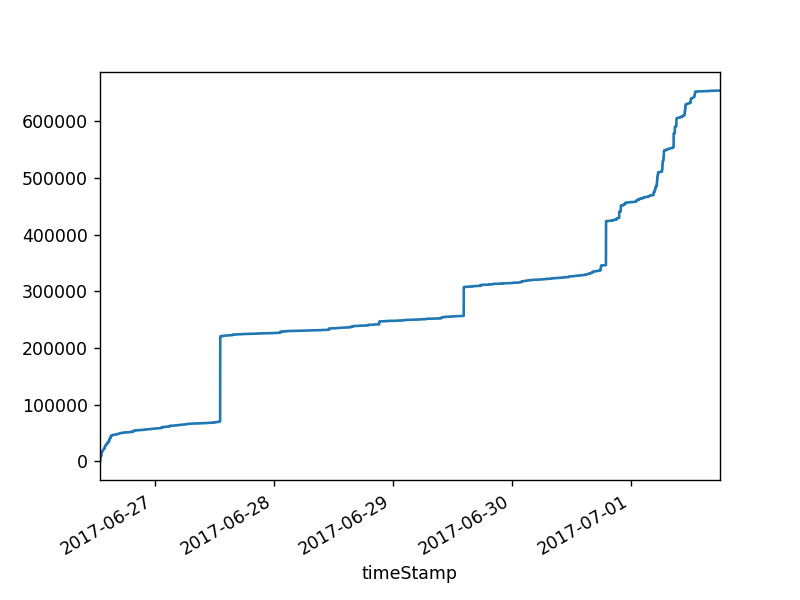

In [34]:
windows.get_group(0)['cumulative'].plot()

In [35]:
windows.get_group(0)['cumulative'].max()

653711.36628541083

<IPython.core.display.Javascript object>


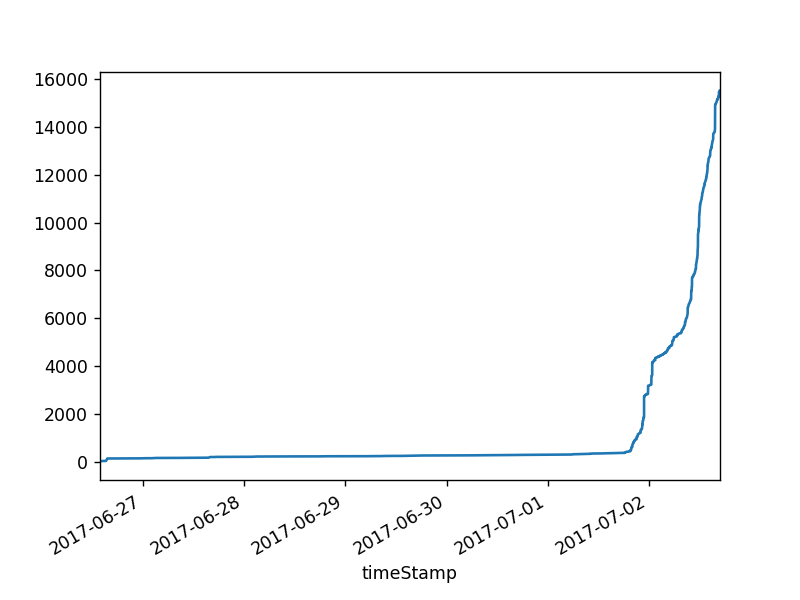

In [22]:
windows.get_group(1)['cumulative'].plot()

In [25]:
windows.get_group(1)['cumulative'].max()

15533.646152511559

<IPython.core.display.Javascript object>


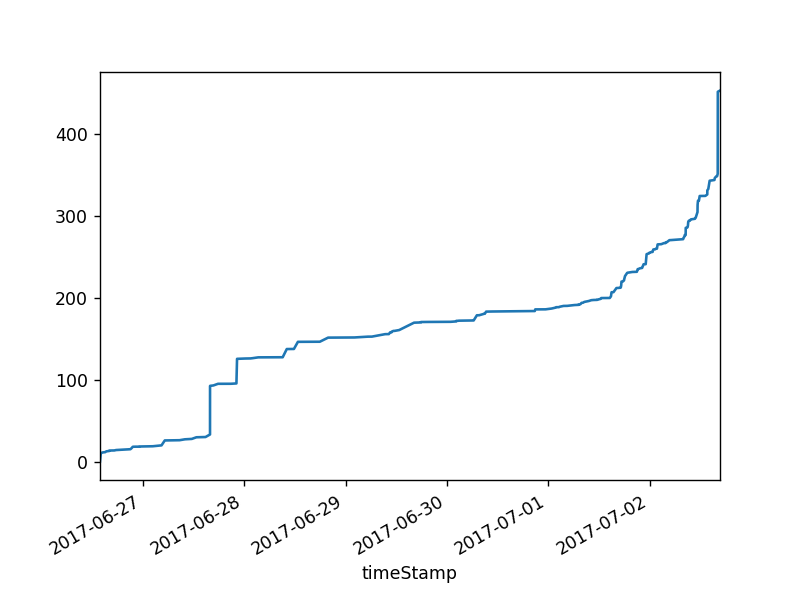

In [23]:
windows.get_group(2)['cumulative'].plot()

In [26]:
windows.get_group(2)['cumulative'].max()

453.34063852542766